In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
run = 'tree_33'
device_use = '/cpu:0'

---
### $$Load\ Packages$$
---

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import pandas as pd
import seaborn as sns
import tensorflow as tf

import cv2 as cv2
import glob as glob
from tqdm import tqdm

In [5]:
import keras
from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation,AveragePooling2D
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.layers.core import Flatten
from keras.losses import categorical_crossentropy

Using TensorFlow backend.


In [6]:
train_path = '../01.data/extracted/images_training_rev1/'
test_path =  '../01.data/extracted/images_test_rev1/'

In [7]:
train_files = glob.glob(train_path+'*.jpg')
test_files = glob.glob(test_path+'*.jpg')

In [8]:
{
    'train':len(train_files),
    'test':len(test_files)
}

{'test': 79975, 'train': 61578}

In [9]:
y_path = '../01.data/extracted/training_solutions_rev1.csv'
train_output = pd.read_csv(y_path,index_col='GalaxyID')


train_output.sort_index(inplace=True)
train_output.head()

,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
GalaxyID,,,,,,,,,,,,,,,,,,,,,
100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,0.0,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,0.0,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,0.0,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [10]:
f1 =  ['Class1.1', 'Class1.2', 'Class1.3']
f2 =  ['Class2.1', 'Class2.2']
f3 =  ['Class3.1', 'Class3.2'] 
f4 =  ['Class4.1', 'Class4.2']
f5 =  ['Class5.1', 'Class5.2', 'Class5.3', 'Class5.4'] 
f6 =  ['Class6.1', 'Class6.2']
f7 =  ['Class7.1', 'Class7.2', 'Class7.3']
f8 =  ['Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5', 'Class8.6', 'Class8.7']
f9 =  ['Class9.1', 'Class9.2', 'Class9.3']
f10 =  ['Class10.1', 'Class10.2', 'Class10.3']
f11 =  ['Class11.1', 'Class11.2', 'Class11.3', 'Class11.4', 'Class11.5', 'Class11.6']

In [11]:
features = ['Class1.1',  'Class1.2',  'Class1.3',
            'Class2.1',  'Class2.2',
            'Class3.1',  'Class3.2', 
            'Class4.1',  'Class4.2', 
            'Class5.1',  'Class5.2',  'Class5.3', 'Class5.4', 
            'Class6.1',  'Class6.2',
            'Class7.1',  'Class7.2',  'Class7.3', 
            'Class8.1',  'Class8.2',  'Class8.3', 'Class8.4', 'Class8.5', 'Class8.6', 'Class8.7',
            'Class9.1',  'Class9.2',  'Class9.3',
            'Class10.1', 'Class10.2', 'Class10.3',
            'Class11.1', 'Class11.2', 'Class11.3', 'Class11.4', 'Class11.5', 'Class11.6']

In [12]:
feature_categories = [f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11]

---
### $$Functions$$
---

In [13]:
def get_image(image_path,size):
    
    x = cv2.imread(image_path)
    x = cv2.resize(x,size)
    
    return(x)

def get_labels(image_path):
    
    image_id = image_path.split('/')[-1]
    image_number = image_id.split('.')[0]
    values = train_output.loc[np.int(image_number)].values
    
    return(values)

---
### $$Parameters$$
---

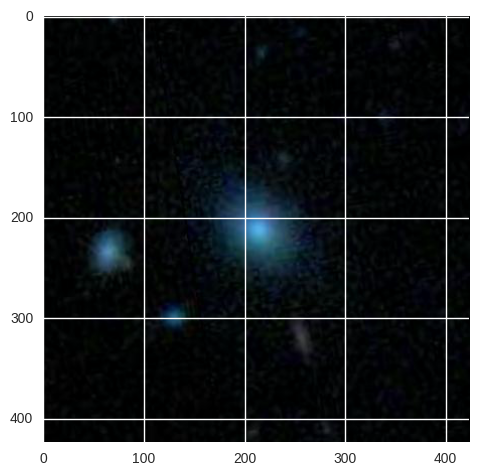

In [14]:
i = np.random.randint(0,len(train_files))

plt.imshow(cv2.imread(train_files[i]));

In [15]:
num_classes = 37
epochs = 1500
input_size = (64,64)
img_rows, img_cols = input_size
img_channels = 3
observations,output_classes = train_output.shape

In [16]:
differ = 25

In [17]:
from gc import collect

n = 1000#len(train_files)

train_x = np.zeros((n,img_rows,img_cols,img_channels),dtype=np.int16)
train_y = np.zeros((n,num_classes),dtype=np.float128)

for current_id in tqdm(range(n),miniters=1000):
    
    if current_id%1000==0:
        collect()
        
    current_path = train_files[current_id]
    
    current_image  = (np.array(get_image(current_path,input_size))-differ).clip(0)
    current_labels = get_labels(current_path)
    
    train_x[current_id] = current_image
    train_y[current_id] = current_labels
    
    
train_y_expanded = np.expand_dims(np.expand_dims(train_y,1),1)

100%|██████████| 1000/1000 [00:27<00:00, 36.04it/s]


In [18]:
print train_x.shape
print train_y.shape
print train_y_expanded.shape

(1000, 64, 64, 3)
(1000, 37)
(1000, 1, 1, 37)


In [19]:
from gc import collect
collect()

0

---
## $$Model$$
---

In [192]:
from keras.models import Input,Model
from keras.layers import Lambda,dot,add,concatenate

In [193]:
K.clear_session()

main_input = Input(shape=(img_rows,img_cols,img_channels), name='main_input')

x = Lambda(lambda x : x*1.0/255)(main_input)

x = BatchNormalization()(x)
x = Conv2D(filters=32, padding='same', kernel_size=(4,4),
           data_format='channels_last', name='Conv-Input-a' )(x)
x = Conv2D(filters=32, padding='same', kernel_size=(4,4),
           name='Conv-Input-b' )(x)
x = Conv2D(filters=32, padding='same', kernel_size=(4,4),
           name='Conv-Input-c' )(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(4,4))(x)
x = Dropout(0.2)(x)




x = BatchNormalization()(x)
x = Conv2D(filters=64, padding='same', kernel_size=(2,2),
           name='Conv-1-a' )(x)
x = Conv2D(filters=64, padding='same', kernel_size=(2,2),
           name='Conv-1-b' )(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.2)(x)




x = BatchNormalization()(x)
x = Conv2D(filters=128, padding='same', kernel_size=(2,2),
           name='Conv-2-a' )(x)
x = Conv2D(filters=128, padding='same', kernel_size=(2,2),
           name='Conv-2-b' )(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.2)(x)




x = BatchNormalization()(x)
x = Conv2D(filters=256, padding='same', kernel_size=(2,2),
           name='Conv-3-a' )(x)
x = Conv2D(filters=256, padding='same', kernel_size=(2,2),
           name='Conv-3-b' )(x)
x = Conv2D(filters=256, padding='same', kernel_size=(2,2),
           name='Conv-3-c' )(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.2)(x)




x = BatchNormalization()(x)
x = Conv2D(filters=512, padding='same', kernel_size=(2,2),
           name='Conv-4-a' )(x)
x = Conv2D(filters=512, padding='same', kernel_size=(2,2),
           name='Conv-4-b' )(x)
x = Conv2D(filters=512, padding='same', kernel_size=(2,2),
           name='Conv-4-c' )(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
features = Dropout(0.2)(x)


#x = BatchNormalization()(x)
#x = Conv2D(filters=1024, padding='same', kernel_size=(2,2),
#           name='Conv-6-a' )(x)
#x = Conv2D(filters=1024, padding='same', kernel_size=(2,2),
#           name='Conv-6-b' )(x)
#x = Conv2D(filters=1024, padding='same', kernel_size=(2,2),
#           name='Conv-6-c' )(x)
#x = Activation('relu')(x)
#x = MaxPooling2D(pool_size=(2,2))(x)
#x = Dropout(0.2)(x)

output = Dense(1024)(features)

model = Model(main_input,output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64, 64, 3)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 3)         12        
_________________________________________________________________
Conv-Input-a (Conv2D)        (None, 64, 64, 32)        1568      
_________________________________________________________________
Conv-Input-b (Conv2D)        (None, 64, 64, 32)        16416     
_________________________________________________________________
Conv-Input-c (Conv2D)        (None, 64, 64, 32)        16416     
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
__________

In [194]:
del model

In [195]:
model_out_shape = tuple(features.shape.as_list()[1:])

In [210]:
class1_prob = Dense(3,activation='softmax')(features)
class1_out = Lambda(lambda x : x,name='Out-class-01')(class1_prob)

In [215]:
class2_prob = Dense(2,activation='softmax')(features)
class2_score = dot([class2_prob,class1_prob],axes=-2)
class2_out = Lambda(lambda x : x[...,1]+K.epsilon(),
                    name='Out-class-02')(class2_score)

In [198]:
class3_prob = Dense(2,activation='softmax')(features)
class3_score = dot(inputs=[class3_prob,class2_prob],axes=-2)
class3_out = Lambda(lambda x : K.expand_dims(x[...,1],axis=1),
                    name='Out-class-03')(class3_score)

In [199]:
class4_prob = Dense(2,activation='softmax')(features)
class4_score = dot(inputs=[class3_out,class4_prob],axes=2)
class4_out = Lambda(lambda x : K.sum(x,axis=-2,keepdims=True),
                    name='Out-class-04')(class4_score)

In [200]:
class10_prob = Dense(3, activation='softmax')(features)
class10_score = dot(inputs=[class10_prob, class4_out], axes=-2)
class10_out = Lambda(lambda x : K.expand_dims(x[...,0], axis=1),
                     name='Out-class-10')(class10_score)

In [201]:
class11_prob = Dense(6, activation='softmax')(features)
class11_score = dot(inputs=[class10_out,class11_prob], axes=2)
class11_out = Lambda(lambda x : K.sum(x,axis=-2, keepdims=True),
                     name='Out-class-11')(class11_score)

In [202]:
class5_prob = Dense(4,activation='softmax')(features)

class5_from_class4 = K.expand_dims(dot(inputs=[class5_prob,class4_out], 
                                       axes=-2)[...,1],axis=1)
class5_from_class11 = K.sum(dot(inputs=[class11_out,class5_prob], axes=-2),
                            axis=-2, keepdims=True)

class5_out = add([class5_from_class4,class5_from_class11],name='Out-class-05')

In [203]:
class6_prob = Dense(2,activation='softmax')(features)
class6_out = Lambda(lambda x : x, name='Out-class-06')(class6_prob)

In [204]:
class7_prob = Dense(3,activation='softmax')(features)
class7_score = dot([class7_prob,class1_prob],axes=-2)[:,:,:,0]
class7_out = Lambda(lambda x : K.expand_dims(x,axis=1),name='Out-class-07')(class7_score)

In [205]:
class8_prob = Dense(7,activation='softmax')(features)
class8_score = dot(inputs=[class8_prob,class6_out],axes=0)[:,:,:,0]
class8_out = Lambda(lambda x : K.expand_dims(x,axis=1),name='Out-class-08')(class8_score)

In [206]:
class9_prob = Dense(3,activation='softmax')(features)
class9_score = dot(inputs=[class9_prob,class2_prob],axes=-2)[:,:,:,0]
class9_out = Lambda(lambda x : K.expand_dims(x, axis=1), name='Out-class-09')(class9_score)

In [218]:
from keras.layers import Concatenate

In [ ]:
from keras.models import Model,Input

main_output = Concatenate([class1_out, 
                           class2_out, 
                           class3_out,  
                           class4_out,
                           class5_out, 
                           class6_out, 
                           class7_out,  
                           class8_out,
                           class9_out, 
                           class10_out, 
                           class11_out],
                          name='Main-output',
                          axis=0)

model = Model(main_input,main_output,name='full-model')
model.summary()

In [174]:
import networkx as nx

computation_structure = nx.DiGraph()

computation_dict = {
    'Q1':['Q7','Q2','Out'],
    'Q2':['Q9','Q3'],
    'Q3':['Q4'],
    'Q4':['Q10','Q5'],
    'Q5':['Q6'],
    'Q6':['Q8','Out'],
    'Q7':['Q6'],
    'Q8':['Out'],
    'Q9':['Q6'],
    'Q10':['Q11'],
    'Q11':['Q5']
}

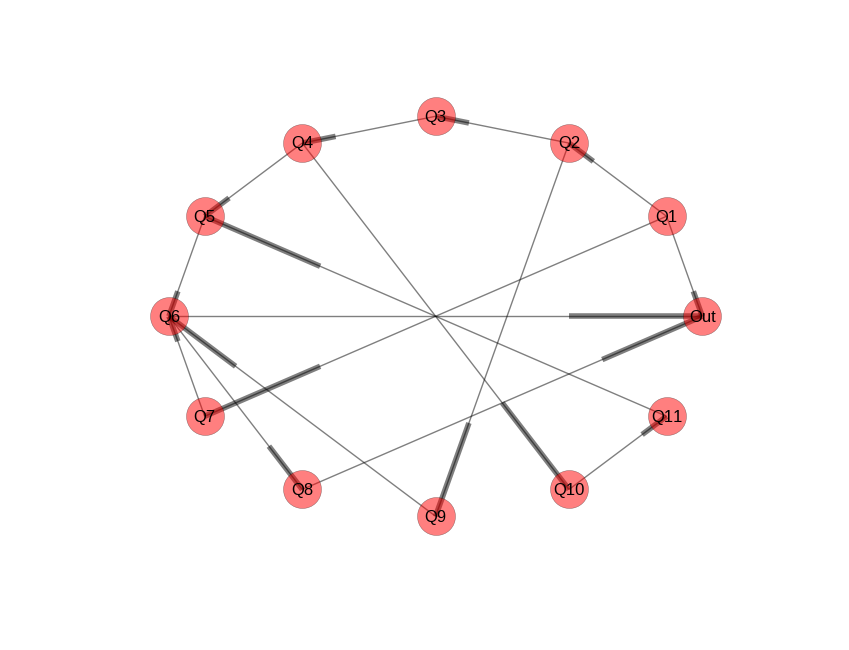

In [139]:
computation_graph = nx.DiGraph()
nx.from_dict_of_lists(computation_dict,create_using=computation_graph)


n = 0
r = 2


graph_pos = {
    'Q1':(r * cos(2*pi*1*1.0/12),r * sin(2*pi*1*1.0/12)), 
    'Q2':(r * cos(2*pi*2*1.0/12),r * sin(2*pi*2*1.0/12)), 
    'Q3':(r * cos(2*pi*3*1.0/12),r * sin(2*pi*3*1.0/12)), 
    'Q4':(r * cos(2*pi*4*1.0/12),r * sin(2*pi*4*1.0/12)), 
    'Q5':(r * cos(2*pi*5*1.0/12),r * sin(2*pi*5*1.0/12)), 
    'Q6':(r * cos(2*pi*6*1.0/12),r * sin(2*pi*6*1.0/12)), 
    'Q7':(r * cos(2*pi*7*1.0/12),r * sin(2*pi*7*1.0/12)), 
    'Q8':(r * cos(2*pi*8*1.0/12),r * sin(2*pi*8*1.0/12)), 
    'Q9':(r * cos(2*pi*9*1.0/12),r * sin(2*pi*9*1.0/12)), 
    'Q10':(r * cos(2*pi*10*1.0/12),r * sin(2*pi*10*1.0/12)), 
    'Q11':(r * cos(2*pi*11*1.0/12),r * sin(2*pi*11*1.0/12)), 
    'Out':(r * cos(2*pi*12*1.0/12),r * sin(2*pi*12*1.0/12))
}

plt.figure(figsize=(8,6))
nx.draw(computation_graph,
        pos=graph_pos,
        alpha=0.5,
        node_size=750,
        with_labels=True)

In [33]:
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras_tqdm import TQDMNotebookCallback

tb = TensorBoard(
        log_dir='../tensorboard/'+run+'/',
        write_graph=True,
        write_images=True
    )

mc = ModelCheckpoint(filepath = '../05.model/'+run+'.h5',
                     save_best_only = True)

ec = EarlyStopping(patience=5,
                   mode='auto')

reduce_lr = ReduceLROnPlateau(factor=0.1,
                              patience=3,
                              min_lr=1e-10)

tqnc = TQDMNotebookCallback()

In [34]:
batch_size = 50

train_steps = 2*np.int(train_x.shape[0]*1.0/batch_size)
validation_steps = np.int(0.1 * train_steps)

In [ ]:
with tf.device(device_use):

    model.compile(loss='mse',
                  optimizer=keras.optimizers.adam(lr=1e-2)
                 )
    
    loss_history = model.fit(
                            x=train_x,
                            y=train_y_expanded,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_split=0.1,
                            callbacks=[tb,mc,ec,reduce_lr,tqnc],
                            verbose=1
    )


loss_df = pd.DataFrame(loss_history.history)
loss_df.to_csv('../03.plots/losses/augmented_loss_df'+run+'.csv',
                   index=False)

from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
                                rotation_range=180,
                                vertical_flip=True,
                                horizontal_flip=True,
                                data_format='channels_last',
                                
)

validation_datagen = ImageDataGenerator(
                                data_format='channels_last'
)

train_generator = train_datagen.flow(
                                    x=train_x,
                                    y=train_y_expanded,
                                    batch_size=batch_size
)

validation_generator = validation_datagen.flow(
                                            x=train_x,
                                            y=train_y_expanded,
                                            batch_size=batch_size
)

with tf.device(gpu):

    model.compile(loss='mse',
                  optimizer=keras.optimizers.adam(lr=1e-2)
                 )
    
    loss_history = model.fit_generator(
                                    generator=train_generator,
                                    validation_data=validation_generator,
                                    epochs=epochs,
                                    steps_per_epoch=train_steps,
                                    validation_steps=validation_steps,
                                    callbacks=[tb,mc,ec,reduce_lr,tqnc],
                                    verbose=0
                )


loss_df = pd.DataFrame(loss_history.history)
loss_df.to_csv('../03.plots/losses/augmented_loss_df'+run+'.csv',
                   index=False)

In [ ]:
sns.set_style('whitegrid')

loss_df.plot(y=['loss','val_loss'])
loss_df.lr.plot(style='r-', secondary_y=True);
plt.legend(loc='center right');

##### Test data

In [ ]:
out_test = {}

for file_path in tqdm(test_files):
    galaxy_id = file_path.split('/')[-1].split('.')[0]
    galaxy_img = np.expand_dims(cv2.resize(cv2.imread(file_path),
                                           input_size),
                                axis=0)
    galaxy_pred = model.predict(galaxy_img).flatten()
    
    out_test[galaxy_id] = galaxy_pred

In [ ]:
columns = pd.read_csv(y_path,
                      index_col='GalaxyID',
                      nrows=0)

test_results = pd.DataFrame.from_dict(data = out_test,
                                      orient='index')
test_results.index.name = 'GalaxyID'
test_results.columns = columns.columns

In [ ]:
test_results.to_csv('../04.results/submission'+run+'.csv',
                    index_label='GalaxyID')

test_results.head()